# Lab 2a: PyTorch and Albumentations for image classification (Optional)

This example shows how to use Albumentations library (https://pypi.org/project/albumentations/) to prepare our data for image classification. For this example, we will use the [`Cats vs. Docs` dataset](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset). At the end of the lab we will have a model to detect whether an image contains a cat or a dog.

For this notebook we will be using the `ml.g4dn.xlarge` instance type

- Download the dataset from the provided link by updating the `<dataset_url>` below
- Unpack the dataset.

**Note**: The unpacking will take ~5-10 minutes.

In [ ]:
!wget -O dataset.tar.gz "<dataset_url>"

In [ ]:
!tar -xzf dataset.tar.gz --no-same-owner

### Import the required libraries

In [ ]:
%pip install albumentations
%pip install pretrainedmodels
%pip install tqdm

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
 
import torchvision.models as models
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import metrics

cudnn.benchmark = True

### Split files from the dataset into the train and validation sets

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 18750 images for training, 6240 images for validation, and 10 images for testing.

In [ ]:
def get_data(data_dir, labels):
    """
    parse the input images and retrieve their paths and labels

    :param data_dir : directory containing training images
    :param labels   : list of output labels, the data_dir should have folder with images for each unique labels
    :return image path and labels
    """
    print(f"Loading the image dataset")
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path), total=len(os.listdir(path))):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, class_num])
            except Exception as e:
                print(e)
    X, y = [], []
    for feature, label in data:
        X.append(feature)
        y.append(label)
    print(f"Done")
    return X, y

In [ ]:
import os

## load the image dataset
labels = ["cat", "dog"]
data_dir = "data/train"

images, targets = get_data(data_dir, labels)

## Crete model directory
if not os.path.exists('model'):
    os.mkdir('model')

In [ ]:
# instead of using kfold, i am using train_test_split
# with a fixed random state
train_images, valid_images, train_targets, valid_targets = train_test_split(
    images, targets, stratify=targets, random_state=42
)

In [ ]:
test_images = valid_images[-10:]
test_targets = valid_targets[-10:]

valid_images = valid_images[:-10]
valid_targets = valid_targets[:-10]

In [ ]:
len(train_images),len(valid_images),len(test_images),








### Define a PyTorch dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

Out task is binary classification - a model needs to predict whether an image contains a cat or a dog. Our labels will mark the probability that an image contains a cat. So the correct label for an image with a cat will be `0.0`, and the correct label for an image with a dog will be `1.0`.

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and return it along with the correct label.

In [ ]:
from PIL import Image
from PIL import ImageFile

# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images

ImageFile.LOAD_TRUNCATED_IMAGES = True


class ClassificationDataset:
    """
    A general classification dataset class that you can use for all
    kinds of image classification problems. For example,
    binary classification, multi-class, multi-label classification
    """

    def __init__(self, image_paths, targets, resize=None, augmentations=None):
        """
        :param image_paths: list of path to images
        :param targets: numpy array
        :param resize: tuple, e.g. (256, 256), resizes image if not None
        :param augmentations: albumentation augmentations
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        """
        Return the total number of samples in the dataset
        """
        return len(self.image_paths)

    def __getitem__(self, item):
        """
        For a given "item" index, return everything we need
        to train a given model
        """
        # use PIL to open the image
        image = Image.open(self.image_paths[item])
        # convert image to RGB, we have single channel images
        image = image.convert("RGB")
        # grab correct targets
        targets = self.targets[item]
        # resize if needed
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )

        # convert image to numpy array
        image = np.array(image)
        # if we have albumentation augmentations
        # add them to the image
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        # pytorch expects CHW instead of HWC
        # image = np.array(image)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # return tensors of image and targets
        # take a look at the types!
        # for regression tasks,
        # dtype of targets will change to torch.float
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

### Use Albumentations to define transformation functions for the train and validation datasets

We use Albumentations to define augmentation pipelines for training and validation datasets. In both pipelines, we first resize an input image, so its smallest size is 160px, then we take a 128px by 128px crop. For the training dataset, we also apply more augmentations to that crop. Next, we will normalize an image. We first divide all pixel values of an image by 255, so each pixel's value will lie in a range `[0.0, 1.0]`. Then we will subtract mean pixel values and divide values by the standard deviation. `mean` and `std` in augmentation pipelines are taken from the [`ImageNet` dataset](http://www.image-net.org/). Still, they transfer reasonably well to the `Cats vs. Dogs` dataset. 

Note that in the validation pipeline we will use `A.CenterCrop` instead of `A.RandomCrop` because we want out validation results to be deterministic (so that they will not depend upon a random location of a crop).

In [ ]:
# fetch the ClassificationDataset class
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)
train_dataset = ClassificationDataset(
    image_paths=train_images,
    targets=train_targets,
    resize=(227, 227),
    augmentations=train_transform,
)

In [ ]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)
# same for validation data
valid_dataset = ClassificationDataset(
    image_paths=valid_images,
    targets=valid_targets,
    resize=(227, 227),
    augmentations=val_transform,
)



### Define helpers for training

In [ ]:
def train(data_loader, model, optimizer, device):
    """
    This function does training for one epoch
    :param data_loader: this is PyTorch dataloader
    :param model: pytorch model
    :param optimizer: optimizer, for e.g. adam, sgd, etc
    :param device: cuda/cpu
    """
    # put the model in train mode
    model.train()

    # go over every batch of data in data loader
    for data in data_loader:
        # we have image and targets
        inputs = data["image"]
        targets = data["targets"]

        # move inputs/targets to cuda/cpu device
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)

        # zero grad the optimizer
        optimizer.zero_grad()
        # do forward step of model
        outputs = model(inputs)
        # calculate loss
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
        # backward step the loss
        loss.backward()
        # step optimizer
        optimizer.step()
        # if you have a scheduler, you either need to
        # step it here or you have to step it after
        # the epoch. Here, we are not using any learning
        # rate scheduler


def evaluate(data_loader, model, device):
    """
    This function does evaluation for one epoch
    :param data_loader: this is the PyTorch DataLoader
    :param model: pytorch model
    :param device: cuda/cpu
    """
    # put model in evaluation mode
    model.eval()

    # init lists to store targets and outputs
    final_targets = []
    final_outputs = []

    # we use no_grad context
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            # do the forward steps to generate prediction
            output = model(inputs)

            # convert targets and outputs to lists
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()

            # extend the original list
            final_targets.extend(targets)
            final_outputs.extend(output)

        # return final output and final targets
        return final_outputs, final_targets
    
def _save_model(model, model_dir):
    """
    save pytorch model

    :param model       : pytorch model
    :param model_dir   : directory to save pytorch model
    """
    print("Saving the model.")
    path = os.path.join(model_dir, "model.pth")
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.cpu().state_dict(), path)


### Define training parameters 

Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc

In [ ]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 1e-5,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 4,
}

In [ ]:
torch.cuda.is_available()

# Create training and validation Dataset and Dataloader

In [ ]:
# # fetch the ClassificationDataset class
# train_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.CenterCrop(height=128, width=128),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
#     ]
# )
# train_dataset = ClassificationDataset(
#     image_paths=train_images,
#     targets=train_targets,
#     resize=(227, 227),
#     augmentations=train_transform,
# )
# # torch dataloader creates batches of data
# # from classification dataset class
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=128, shuffle=True, num_workers=4
# )
# val_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.CenterCrop(height=128, width=128),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
#     ]
# )
# # same for validation data
# valid_dataset = ClassificationDataset(
#     image_paths=valid_images,
#     targets=valid_targets,
#     resize=(227, 227),
#     augmentations=val_transform,
# )
# valid_loader = torch.utils.data.DataLoader(
#     valid_dataset, batch_size=128, shuffle=False, num_workers=4
# )



### Define the Model

<img src = "fine_tune.png" height = 50 width = 800>

In [ ]:
import pretrainedmodels

def get_model(pretrained, trainable_layer_count="all"):
    if pretrained:
        model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
    else:
        model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
    print(f"Number of trainable layers -- {trainable_layer_count}")
    if trainable_layer_count == "all":
        # the full pre-trained model is fine-tuned in this case
        for child in model.children():
            for param in child.parameters():
                param.requires_grad = True
    return model

In [ ]:
model = get_model(pretrained=True, trainable_layer_count=6)

model.last_linear = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=1),
    nn.Sigmoid(),
)
model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])


### Data Loader 

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=128, shuffle=False, num_workers=4
)

## Training Loop Begins !

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=0.01)
# train and print accuracy score for all epochs
best_acc = 0
best_epoch = -1
for epoch in tqdm(range(params["epochs"])):
    model.to(params["device"])
    print(f"epoch -- {epoch}")
    train(train_loader, model, optimizer, device=params["device"])
    predictions, valid_targets = evaluate(valid_loader, model, device=params["device"])
    predictions = np.array([x[0] for x in predictions])
    preds = np.where(predictions > 0.5, 1, 0)
    accuracy = metrics.accuracy_score(valid_targets, preds)

    print(f"Epoch={epoch}, Valid accuracy = {accuracy}")
    if accuracy > best_acc:
        print("Best epoch until now....")
        best_acc = accuracy
        best_epoch = epoch
        print(f"Saving model to model")
        _save_model(model, "model")
print(f"Best accuracy - {best_acc} at epoch - {best_epoch}")
print("Finished Training")

### Predict labels for images and visualize those predictions

Now we have a trained model, so let's try to predict labels for some images and see whether those predictions are correct. First we make the `ClassificationInferenceDataset` PyTorch dataset. Its code is similar to the training and validation datasets, but the inference dataset returns only an image and not an associated label (because in the real world we usually don't have access to the true labels and want to infer them using our trained model).

In [ ]:
class ClassificationInferenceDataset:
    """
    A general classification dataset class that you can use for all
    kinds of image classification problems. For example,
    binary classification, multi-class, multi-label classification
    """

    def __init__(self, image_paths, resize=None, augmentations=None):
        """
        :param image_paths: list of path to images
        :param targets: numpy array
        :param resize: tuple, e.g. (256, 256), resizes image if not None
        :param augmentations: albumentation augmentations
        """
        self.image_paths = image_paths
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        """
        Return the total number of samples in the dataset
        """
        return len(self.image_paths)

    def __getitem__(self, item):
        """
        For a given "item" index, return everything we need
        to train a given model
        """
        # use PIL to open the image
        image = Image.open(self.image_paths[item])
        # convert image to RGB, we have single channel images
        image = image.convert("RGB")
        # grab correct targets
        # resize if needed
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )

        # convert image to numpy array
        image = np.array(image)
        # if we have albumentation augmentations
        # add them to the image
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        # pytorch expects CHW instead of HWC
        # image = np.array(image)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # return tensors of image and targets
        # take a look at the types!
        # for regression tasks,
        # dtype of targets will change to torch.float
        return {
            "image": torch.tensor(image, dtype=torch.float)
        }

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)

test_dataset = ClassificationInferenceDataset(
    image_paths=test_images,
    resize=(227, 227),
    augmentations=test_transform,
)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [ ]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        inputs = images["image"]

        # move inputs/targets to cuda/cpu device
        inputs = inputs.to("cpu", dtype=torch.float) 
        output = model(inputs)        
        # predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predictions = (output <= 0.5)[:, 0].cpu().numpy()
        predicted_labels += ["cat" if is_cat else "dog" for is_cat in predictions]

In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        print(true_label,predicted_label)
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

cat cat
dog dog
dog dog
cat cat
cat cat
cat cat
cat cat
cat cat
cat cat
dog dog


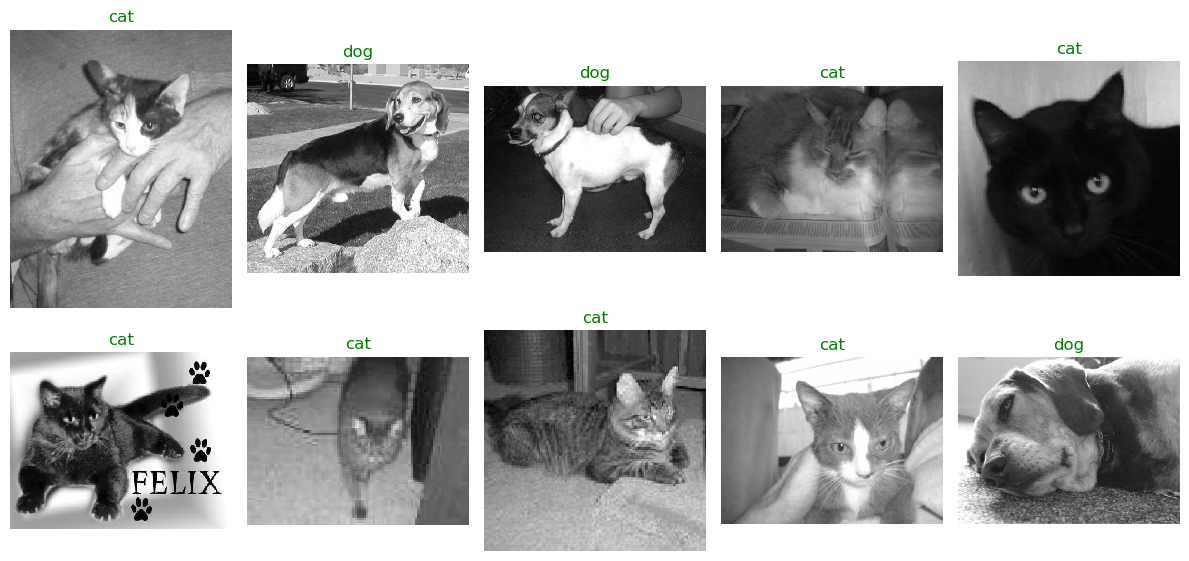

In [118]:
display_image_grid(test_images, predicted_labels)

As we see our model predicted correct labels for 7 out of 10 images. If you train the model for more epochs, you will obtain better results.